In [1]:
from pathlib import Path
from tqdm import tqdm
import keras
import matplotlib.pyplot as plt
import os
import pydicom
import numpy as np
from skimage import measure, morphology
from sklearn.model_selection import train_test_split
import scipy
from sklearn.feature_extraction import image

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Write to normal_256auto.txt that all the data that has a correct dimention and is labelled as normal in excel
data_dir = '../../data'
image_dir = data_dir + '/256Auto/images'
mask_dir = data_dir + '/256Auto/masks'
normal = data_dir + '/normal.txt'
green = data_dir + '/green.txt'

files = os.listdir(image_dir)
image_list = [[pydicom.read_file(os.path.join(image_dir, filename)), filename] for filename in files]
#normal_list = pydicom.read_file(os.path.join(data_dir, 'normal.txt'))
with open(normal) as f:
    content = f.readlines()
normal_list = [x.strip() for x in content] 
images = []
text_file = open(data_dir + "/normal_256auto.txt", "w")
text_file_temp = open(data_dir + "/shapes.txt", "w")
for i in range(len(image_list)):
    text_file_temp.write(image_list[i][1] + str(image_list[i][0].pixel_array.shape) + "\n")
    if image_list[i][0].pixel_array.shape == (220,256,256):
        if image_list[i][1].split('.')[0] in normal_list:
            text_file.write(image_list[i][1] + "\n")
text_file.close()
text_file_temp.close()

Will load masks:  ['A071.result.dcm', 'A030.result.dcm', 'A082.result.dcm', 'A010.result.dcm', 'A073.result.dcm', 'A040.result.dcm', 'A027.result.dcm', 'A022.result.dcm', 'A066.result.dcm', 'A091.result.dcm', 'A123.result.dcm', 'A133.result.dcm', 'A088.result.dcm', 'A135.result.dcm', 'A070.result.dcm', 'A056.result.dcm', 'A137.result.dcm']
(220, 256, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(220, 256, 256) (220, 256, 256)
50
77
69
118
71
64
36
38
59
77
0
124
59
72
73
109
0


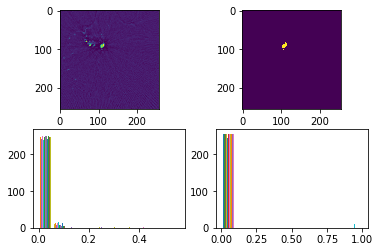

In [3]:
# Load data and masks
data_dir = '../../data'
filenames = data_dir + '/normal_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

with open(filenames) as f:
    content = f.readlines()
normal_namelist = [x.strip() for x in content] 

#Get good image names
files = os.listdir(img_dir)
img_name_list = []
for filename in files:
    if filename in normal_namelist:
        img_name_list.append(filename)

#Get corresponding masks names, delete from both name lists if mask does not exists
files = os.listdir(msk_dir)
msk_name_list = []
invalid_img_list = []
for filename in img_name_list:   #correspond images loaded
    img_namesplt = filename.split('.')
    msk_name = img_namesplt[0]+'.result.dcm'
    try:
        pydicom.read_file(os.path.join(msk_dir, msk_name))
    except:
        #print(filename + " does not have a result dicom file in the mask folder! will delete that from image lists")
        invalid_img_list.append(filename)
    else:
        msk_name_list.append(msk_name)
        
for filename in invalid_img_list:
    img_name_list.remove(filename)     
#img_name_list.remove(filename for filename in invalid_img_list)   #why not working?
#print("Will load images: ",img_name_list)
print("Will load masks: ", msk_name_list)

#Read files (including headings for easier later normalization)
img_list = [pydicom.read_file(os.path.join(img_dir, filename)) for filename in img_name_list ]
msk_list = [pydicom.read_file(os.path.join(msk_dir, filename)) for filename in msk_name_list ]

#Extract pixel value and normalize to 0-1
x_list = [(imagefile.pixel_array-imagefile.SmallestImagePixelValue)/(imagefile.LargestImagePixelValue - imagefile.SmallestImagePixelValue) for imagefile in img_list ]
y_list = [(mskfile.pixel_array==1024).astype(int) for mskfile in msk_list]
print(y_list[0].shape)


#Check some layer to see whether the label size makes sense -> makes sense
show = plt.figure()
show.add_subplot(2,2,1)
#plt.imshow(x_list[0][66])
#show.add_subplot(1,2,2)
plt.imshow(x_list[0][77])

#plt.imshow(y_list[0][66])
show.add_subplot(2,2,2)
plt.imshow(y_list[0][77])
show.add_subplot(2,2,3)
#plt.imshow(x_list[0][66])
#show.add_subplot(1,2,2)
plt.hist(x_list[0][77])

#plt.imshow(y_list[0][66])
show.add_subplot(2,2,4)
plt.hist(y_list[0][77])


print(y_list[0][66][77])

#Print out how many layers has aneurysm info for each of file
print(x_list[0].shape, x_list[15].shape)
check_zeros = []
for j in range(len(y_list)):
    for i in range(220):
        check_zeros.append (np.any(np.asarray(y_list[j][i])))
        #print(np.nonzero(np.asarray(y_list[j][i])))
    print(sum(np.asarray(check_zeros)))
    check_zeros = []

In [7]:
'''
@pram:  origin - a numpy array of a 3d stack for training data
        labelImg - must have the same depth of origin, labelled data
        depth - preferred number of slices per output stack (please make it a even number for now)
        size - 
        complete - False: only output stackes surrounding aneurysm; True: output as much as possible the whole images
@output: n_stack - number of stacks containing of n_slices slices from the images
         stacks - a list of output stacks
@author: Yuan
'''
def to3dpatches (origin, labelImg, depth = 32, size = 32, complete = False, toBoxes = True):
    originStacks = []
    labelStacks = []
    origin_boxes = []
    label_boxes = []
    print(origin.shape, labelImg.shape)
    
    if complete:                                  #Directly output stacks if complete is set to true
        n_stack =int(labelImg.shape[0]/depth)
        output_start_index = int((labelImg.shape[0]%depth)/2)
        output_start_index = output_start_index if output_start_index > 0 else 0

        for i in range(n_stack):
            start_index = output_start_index + i * depth
            originStacks.append(origin[start_index:start_index+depth, ...]) 
            labelStacks.append(labelImg[start_index:start_index+depth, ...])   
    
        #return n_stack, stacks
    else:
        check_zeros = []
        for i in range(labelImg.shape[0]):
            check_zeros.append(np.any(np.asarray(labelImg[i]))) #check every slice along z axis (depth)
        
        non_zero_index = np.nonzero(check_zeros)
        try:
            non_zero_range = [np.amin(non_zero_index), np.amax(non_zero_index)]
        except ValueError as err:
            print("Very likely to contain zero information in the labelled data")
            return err
    
        n_object_slice = non_zero_range[1] - non_zero_range[0]  
        n_stack = int(n_object_slice/depth) + 1
    #print(non_zero_range)
        output_start_index = int(non_zero_range[0]+n_object_slice/2 - n_stack*depth/2)
        output_start_index = output_start_index if output_start_index > 0 else 0

    
        for i in range(n_stack):
            start_index = output_start_index + i * depth
            originStacks.append(origin[start_index:start_index+depth, ...])   # Cut middle stackes
            labelStacks.append(labelImg[start_index:start_index+depth, ...])   # Cut middle stackes
        
        if(origin.shape[1]%size != 0):
            print("Err: the images cannot be divided to boxes!")
            return -1
    if toBoxes:
        n_alongaxis = int(origin.shape[1]/size)    #only consider x = y for our project
        for origin_stack, label_stack in zip(originStacks, labelStacks):
            for i in range(n_alongaxis):
                for j in range(n_alongaxis):
                    origin_boxes.append(origin_stack[:,i*size:(i+1)*size,j*size:(j+1)*size])
                    label_boxes.append(label_stack[:,i*size:(i+1)*size,j*size:(j+1)*size])
        return len(origin_boxes), origin_boxes, label_boxes
    else:
        return n_stack, originStacks, labelStacks

stacknumber, trainStack ,labeledStack = to3dpatches(x_list[0], y_list[0], complete = False, toBoxes = False)
print(stacknumber, len(trainStack), trainStack[0].shape, labeledStack[0].shape)

(220, 256, 256) (220, 256, 256)
2 2 (32, 256, 256) (32, 256, 256)
